# Projet: Walmart Sales

> Le service marketing de Walmart nous a demandé de construire un modèle de machine learning capable d'**estimer les ventes hebdomadaires** dans leurs magasins, avec la meilleure précision possible sur les prédictions faites. Un tel modèle les aiderait à mieux comprendre comment les ventes sont influencées par les indicateurs économiques, et pourrait être utilisé pour planifier de futures campagnes marketing.


## Import des modules

In [495]:
import pandas as pd
import numpy as np

from summarytools import dfSummary

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns


## Part 1 : Exploration des données (EDA)

### Chargement & aperçu du dataset

In [496]:
sales_df = pd.read_csv("./data/Walmart_Store_sales.csv")
display(sales_df.head(15))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
8,14.0,10-12-2010,2600519.26,0.0,30.54,3.109,NaN,NaN
9,3.0,NaN,418925.47,0.0,60.12,3.555,224.132020,6.833


In [497]:
dfSummary(sales_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Store[float64],Mean (sd) : 9.9 (6.2)min < med < max:1.0 < 9.0 < 20.0IQR (CV) : 11.8 (1.6),20 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqRJREFUeJzt3L2O2kAYRuFvYEHmR0YIBTqalJFSUHIRudhcQgqugCJNKjokhEA4izCGNIkUKSvAM3g9r3KefmzLHO3a47Hd9Xo1IHaNug8AeMRLlRt3znXMrB2widP1en191vFAV2WhOuc6o9HoS5qmQ99t7Pf7rXPuK7Giyr+o7TRNh/P5/HUwGBzLDt7tdslisRhuNpu2mRHqf67Sf/1mZoPB4Dgej396Du889WAgi5spSCBUSCBUSCBUSCBUSLh71x8waZ9eLpeWxzjgHzdDDZm0z/M8KYri0/F4/GZmvtNTgJnd/4vqPWm/Wq2Gy+Wyez6fmwHHB5jZgxP+PpP22+2WyXoPda6PiHltRuVPpvC4OtdHxL42g1DjUuf6iKjXZhBqhOpcHxHr2gzmUSGBUCGBUCEh6mvUoihaZpY653yGN8zsErB7XoMpKfD3unm+ow01y7JWnuefp9Nps9lslroLLYqilWXZx36//6PRaOQ+++c1mHJCfi+z++c72lBPp9NLkiTd2Wx2nEwm2zJjfz8V+zCbzb6XHWvGazA+Qn6vR853tKH+0ev1vJ+K+Yz9C0/WPASc85vnm5spSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSIh+hX9dqnxRDeUR6huqflEN5RHqG6p+UQ3lEeoNvi+qFUWRmt9lQ/BXugMuWaL+QjihPlnIZUPoV7rr3HfVCPXJnvA9Au+vdNe576oRakVCvkegvO+qMI8KCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCYQKCQ+93Lfb7ZKyGz4cDomZWZZlyXq97r7neNV9qx536PhH+voFFZuzrdobIpMAAAAASUVORK5CYII="">",0(0.0%)
2,Date[object],1. nan2. 19-10-20123. 07-01-20114. 10-12-20105. 28-05-20106. 25-03-20117. 25-06-20108. 18-06-20109. 12-08-201110. 12-11-201011. other,18 (12.0%)4 (2.7%)4 (2.7%)3 (2.0%)3 (2.0%)3 (2.0%)3 (2.0%)3 (2.0%)3 (2.0%)3 (2.0%)103 (68.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA+BJREFUeJzt3UFqG1kARdGvIEwykRAGLUaL6MX2Imo3wqgGcchEPUjSWLHpiVU3lvqcmSeFwJcSVfxnr87n84DCpz/9Afj/EBsZsZERGxmxkREbGbGRERsZsZFZjTG+jDEernS97+fz+flK1+LOrB8fH//abDa7a1xsnuen1Wr1t+B4y3qz2ewOh8Pzdrv99p4LnU6nz9M07Y7H48MYQ2y8sh5jjO12+22/33+9wvW+XOEa3CkPCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmY9xo+zaO+90DWuwX1bz/P8NE3TblzhLNo8z09jjO/v/1jcIxsEMit/MovKW3c2dycW8WpdZSHFUi7WVRZSLOmtdZWFFIvwUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MxeDFaIUlvRq8GK2wFMfCyRi8kHFnI2PwQsbghYzBCxkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjWDgZgxcyHhDI/P416iuUxVysqyyrWNKnX+uqw+Hw/DO6a/07SLjw77rq58+WVSzGAwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZi3UVLOnlusqyikU5Fk7GuoqMOxsZgxcyBi9kDF7IeKlLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjMELGcfCyRi8kHFnI2PwQsbghYzBCxkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjI2CGSsq8i4s5GxriJjXUXGuoqMl7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQcSycjMELGXc2MgYvZAxeyBi8kPFSl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzKOhZMxeCHjAYGMr1Ey1lVkrKvIWFeR8YBARmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGcfCyVhXkXFnI2PwQsbghYzBCxkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjWDgZgxcyv9/Z+Lhu/lvnYvDCx3UPY6T1r8HLix0CH8zpdPo8TdPueDw+jDFuN7Yxfgxe9vv91z/9YfhPNz9G8lKXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMHLDbiX38/LwcvNH2G5Z/cwRnIs/Hbc/LFwgxcyHhDIiI2M2MiIjYzYyIiNjNjIiI2M2Mj8A5zY+DoU3NqbAAAAAElFTkSuQmCC"">",18(12.0%)
3,Weekly_Sales[float64],Mean (sd) : 1249535.8 (647463.0)min < med < max:268929.0 < 1261423.9 < 2771397.2IQR (CV) : 1201310.5 (1.9),136 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAsVJREFUeJzt3L1uGkEUQOE7YNDyo0WIBDqalJFSUPIQedg8QpB4Ago3qeiQVmgRGyOWhRRREFEkAzOMPXdyvtqznuIYc1lmzel0EiB0tffeAHCLp2s/YIxpiUjT8vr70+n0YrkWOHs1VGNMazAYfE3TtG9z8c1mszbGfCNWuLr2itpM07Q/nU5fer3e7p4L53mezOfzfpZlTREhVDi5+q9fRKTX6+2Gw+FPi+u3LNYA/2CYggqEChUIFSoQKlQgVKhAqFDhpo+n8HYc7wSKRHo3kFAD4nonUCTeu4GEGhbrO4Eicd8NJNQAOdwJFIn0biDDFFQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFChaC/PaX1cUIO+06Px2Pj0fuJQbChan2ckMu+y7JMqqr6vNvtvouI7df8ohRsqKL3cULW+14ul/3FYtE+HA51X5vTKuRQRUTv44Rs9r1er6P80vMjMExBBa+vqFVVNUQkNc


L'objectif est de prédire les ventes hebdomadaires `Weekly_Sales`. 14 valeurs manquantes dont les lignes seront supprimées.

C'est un ***petit*** dataset! 150 lignes seulement. Avec des données concernant 20 magasins.

| Colonne | Type | Description |
| - | - | - |
| Store | num | ID du magasin |
| Date | date (as string) |  date de la semaine de vente |
| Weekly_Sales | num |  volume de vente hebdomadaire |
| Holiday_Flag | bool |  période de vacances |
| Temperature | num |  température du jour (donne une idée grossière du temps) |
| Fuel_Price | num |  prix de l'essence dans la région du magasin |
| CPI | num |  indice des prix à la consommation (aprés analyse, spécifique à chaque magasin)
| Unemployment | num |  taux de chômage |


In [498]:
# Typage des colonnes
sales_df["Date"] = pd.to_datetime(sales_df['Date'], format='%d-%m-%Y')
sales_df["Holiday_Flag"] = sales_df["Holiday_Flag"].astype('bool')

sales_df["Store"] = sales_df["Store"].astype('int')

In [499]:
sales_df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag              bool
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

### Elimination des lignes invalide ou doubles

In [500]:
# Pas de target => inexploitable
sales_df = sales_df.dropna(subset=["Weekly_Sales"])

# Pas de date => on pourra rien en faire à priori !
sales_df = sales_df.dropna(subset=["Date"])

print("New shape: ", sales_df.shape)

New shape:  (118, 8)


In [501]:
# Supprimer les doublons exacts s’il y en a
sales_df.drop_duplicates(inplace=True)
print("New shape: ", sales_df.shape)

New shape:  (118, 8)


### Feature engineering: décomposition de la date

In [502]:
# Décomposition de la date
sales_df["Date"] = pd.to_datetime(sales_df["Date"], format="%d-%m-%Y")

sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Week"] = sales_df["Date"].dt.isocalendar().week
sales_df["Day"] = sales_df["Date"].dt.day
sales_df["DayOfWeek"] = sales_df["Date"].dt.dayofweek

date_columns = ["Year", "Month", "Week", "Day", "DayOfWeek"]

# Enforce int type
sales_df[date_columns] = sales_df[date_columns].convert_dtypes()

sales_df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,DayOfWeek
0,6,2011-02-18,1572117.54,True,59.61,3.045,214.777523,6.858,2011,2,7,18,4
1,13,2011-03-25,1807545.43,False,42.38,3.435,128.616064,7.470,2011,3,12,25,4
4,6,2010-05-28,1644470.66,False,78.89,2.759,212.412888,7.092,2010,5,21,28,4
5,4,2010-05-28,1857533.70,False,NaN,2.756,126.160226,7.896,2010,5,21,28,4
6,15,2011-06-03,695396.19,False,69.80,4.069,134.855161,7.658,2011,6,22,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,3,2012-10-19,424513.08,False,73.44,3.594,226.968844,6.034,2012,10,42,19,4
145,14,2010-06-18,2248645.59,False,72.62,2.780,182.442420,8.899,2010,6,24,18,4
147,17,2010-06-11,845252.21,False,57.14,2.841,126.111903,NaN,2010,6,23,11,4
148,8,2011-08-12,856796.10,False,86.05,3.638,219.007525,NaN,2011,8,32,12,4


In [503]:
sales_df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag              bool
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Year                     Int32
Month                    Int32
Week                    UInt32
Day                      Int32
DayOfWeek                Int32
dtype: object

### Data viz

In [504]:
numerical_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
categorical_cols = ["Store", "Holiday_Flag", "Year", "Month", "Week", "Day", "DayOfWeek"]


In [505]:
# Statistiques descriptives
sales_df.describe()


,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,DayOfWeek
count,118.000000,118,1.180000e+02,107.000000,107.000000,109.000000,107.000000,118.0,118.0,118.0,118.0,118.0
mean,9.949153,2011-04-23 04:28:28.474576384,1.257271e+06,60.711589,3.291542,177.718009,7.681299,2010.822034,6.338983,25.423729,16.440678,4.0
min,1.000000,2010-02-05 00:00:00,2.689290e+05,18.790000,2.514000,126.111903,5.143000,2010.0,1.0,1.0,1.0,4.0
25%,4.250000,2010-07-30 00:00:00,5.774276e+05,45.465000,2.824000,131.637000,6.664000,2010.0,4.0,15.25,10.0,4.0
50%,9.000000,2011-04-29 00:00:00,1.331001e+06,61.790000,3.308000,194.379637,7.484000,2011.0,6.0,25.0,16.5,4.0
75%,15.000000,2011-12-31 18:00:00,1.810591e+06,75.430000,3.691500,214.777523,8.150000,2011.75,9.0,36.0,24.0,4.0
max,20.000000,2012-10-19 00:00:00,2.771397e+06,91.650000,4.193000,226.968844,14.313000,2012.0,12.0,52.0,31.0,4.0
std,6.066367,NaN,6.625056e+05,17.961676,0.486784,39.816657,1.678155,0.812628,3.173664,13.783061,8.209378,0.0


#### Analyse univariée

##### Valeur catégorielles

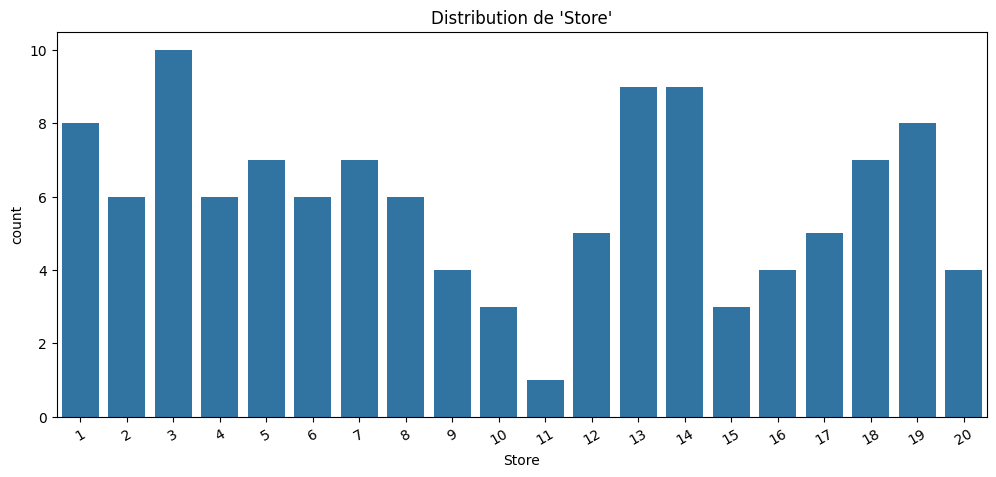

Store = 3: 8.47%
Store = 13: 7.63%
Store = 14: 7.63%
Store = 19: 6.78%
Store = 1: 6.78%
Store = 7: 5.93%
Store = 18: 5.93%
Store = 5: 5.93%
Store = 8: 5.08%
Store = 4: 5.08%
Store = 6: 5.08%
Store = 2: 5.08%
Store = 12: 4.24%
Store = 17: 4.24%
Store = 16: 3.39%
Store = 20: 3.39%
Store = 9: 3.39%
Store = 15: 2.54%
Store = 10: 2.54%
Store = 11: 0.85%


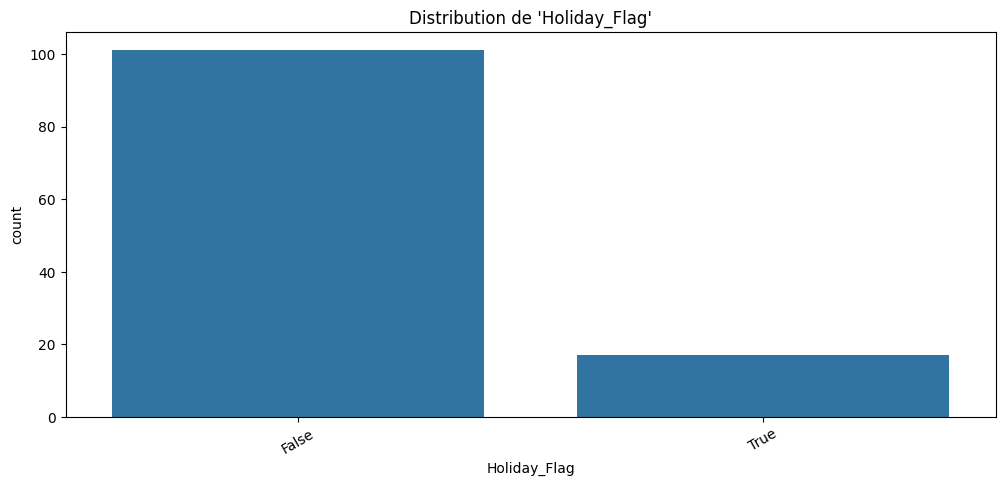

Holiday_Flag = False: 85.59%
Holiday_Flag = True: 14.41%


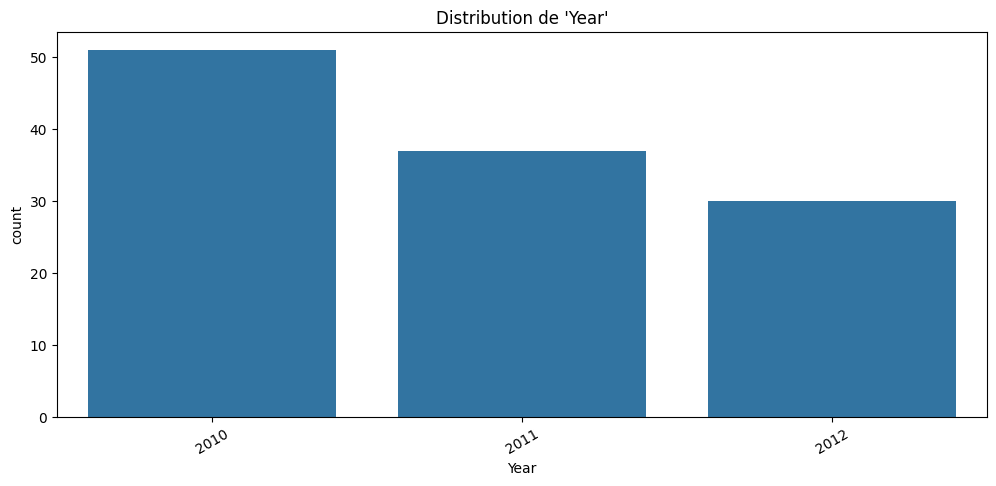

Year = 2010: 43.22%
Year = 2011: 31.36%
Year = 2012: 25.42%


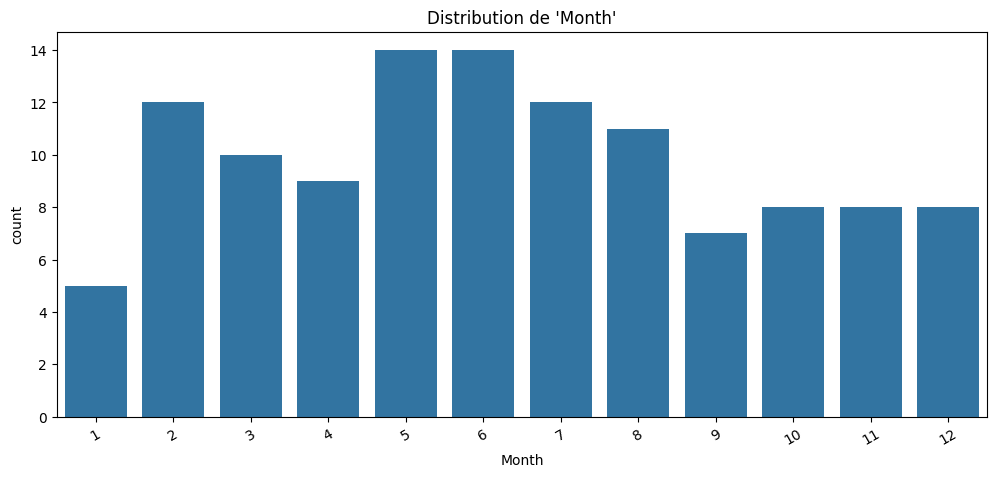

Month = 6: 11.86%
Month = 5: 11.86%
Month = 2: 10.17%
Month = 7: 10.17%
Month = 8: 9.32%
Month = 3: 8.47%
Month = 4: 7.63%
Month = 12: 6.78%
Month = 10: 6.78%
Month = 11: 6.78%
Month = 9: 5.93%
Month = 1: 4.24%


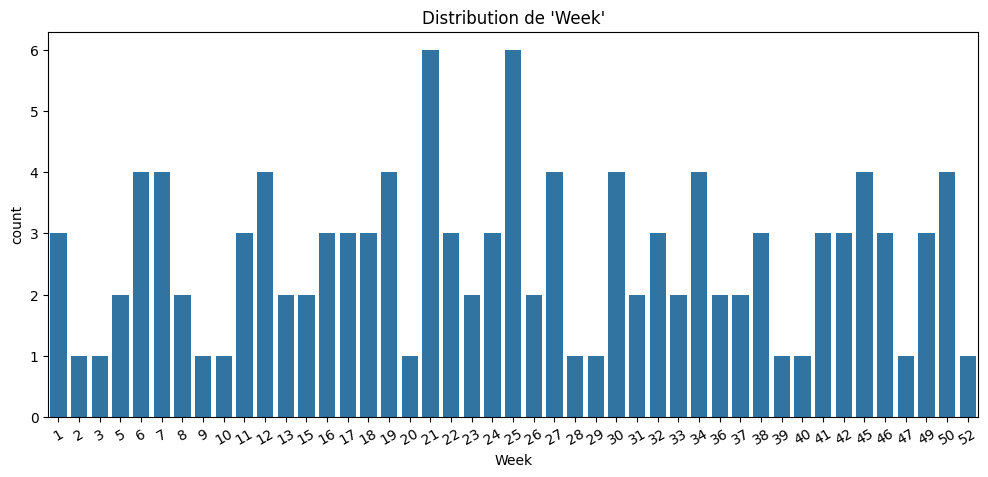

Week = 21: 5.08%
Week = 25: 5.08%
Week = 7: 3.39%
Week = 50: 3.39%
Week = 12: 3.39%
Week = 34: 3.39%
Week = 45: 3.39%
Week = 27: 3.39%
Week = 30: 3.39%
Week = 6: 3.39%
Week = 19: 3.39%
Week = 17: 2.54%
Week = 22: 2.54%
Week = 1: 2.54%
Week = 46: 2.54%
Week = 16: 2.54%
Week = 11: 2.54%
Week = 49: 2.54%
Week = 41: 2.54%
Week = 18: 2.54%
Week = 38: 2.54%
Week = 32: 2.54%
Week = 42: 2.54%
Week = 24: 2.54%
Week = 5: 1.69%
Week = 13: 1.69%
Week = 33: 1.69%
Week = 8: 1.69%
Week = 37: 1.69%
Week = 36: 1.69%
Week = 15: 1.69%
Week = 31: 1.69%
Week = 26: 1.69%
Week = 23: 1.69%
Week = 39: 0.85%
Week = 20: 0.85%
Week = 2: 0.85%
Week = 10: 0.85%
Week = 28: 0.85%
Week = 9: 0.85%
Week = 52: 0.85%
Week = 47: 0.85%
Week = 3: 0.85%
Week = 29: 0.85%
Week = 40: 0.85%


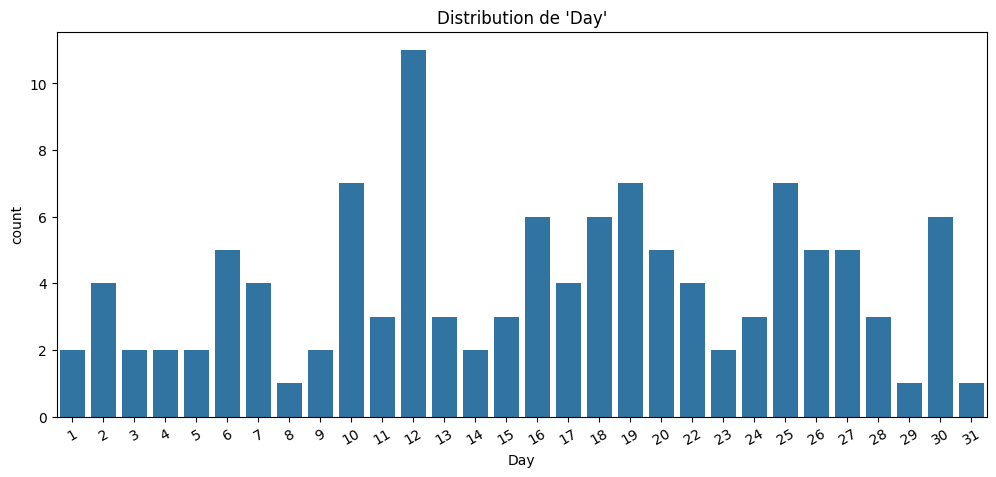

Day = 12: 9.32%
Day = 25: 5.93%
Day = 10: 5.93%
Day = 19: 5.93%
Day = 16: 5.08%
Day = 18: 5.08%
Day = 30: 5.08%
Day = 20: 4.24%
Day = 6: 4.24%
Day = 26: 4.24%
Day = 27: 4.24%
Day = 17: 3.39%
Day = 2: 3.39%
Day = 7: 3.39%
Day = 22: 3.39%
Day = 28: 2.54%
Day = 15: 2.54%
Day = 13: 2.54%
Day = 11: 2.54%
Day = 24: 2.54%
Day = 1: 1.69%
Day = 3: 1.69%
Day = 14: 1.69%
Day = 23: 1.69%
Day = 4: 1.69%
Day = 5: 1.69%
Day = 9: 1.69%
Day = 31: 0.85%
Day = 29: 0.85%
Day = 8: 0.85%


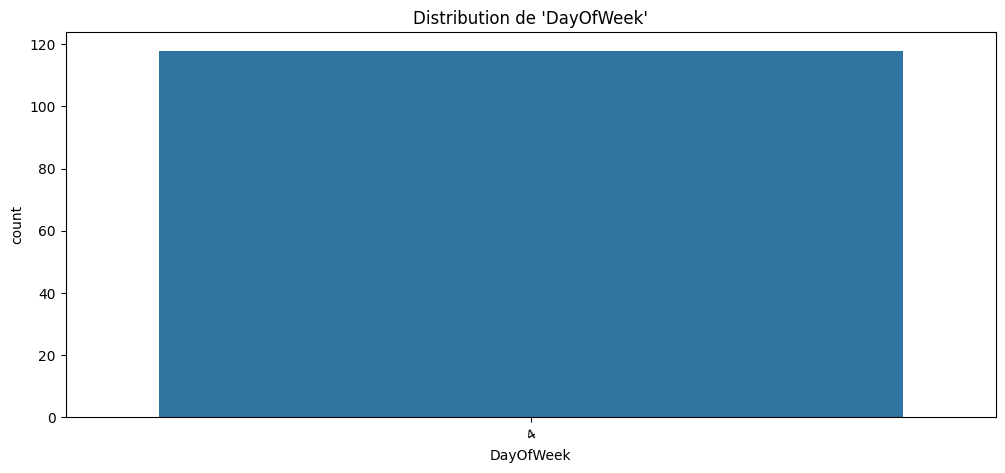

DayOfWeek = 4: 100.00%


In [506]:
for col in categorical_cols:
    plt.figure(figsize=(12, 5))
    sns.countplot(x=col, data=sales_df)
    plt.title(f"Distribution de '{col}'")
    plt.xticks(rotation=30)
    plt.show()
    
    dist = sales_df[col].value_counts(normalize=True) * 100
    for value, pct in dist.items():
        print(f"{col} = {value}: {pct:.2f}%")

##### Valeurs numériques

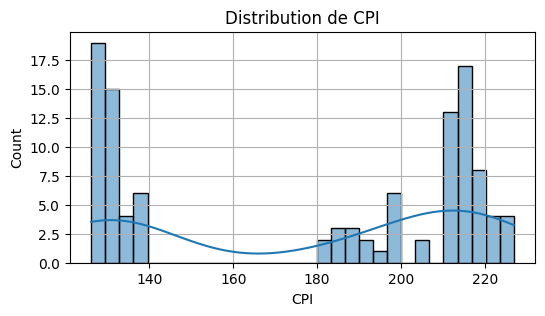

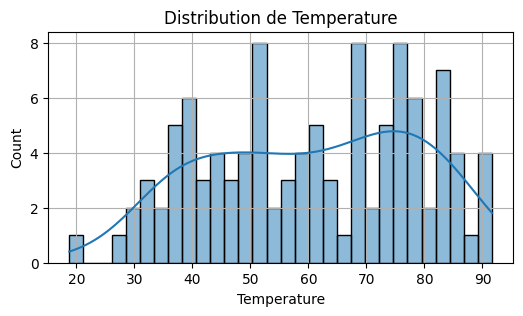

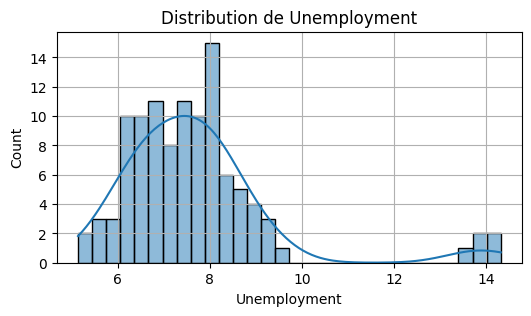

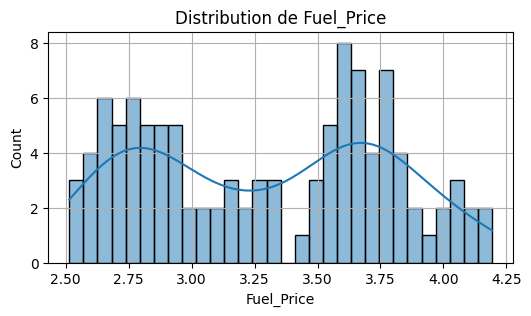

In [507]:
# Visualisation des distributions des variables ayant des valeurs nulles
for col in ["CPI", "Temperature", "Unemployment", "Fuel_Price"]:
    if sales_df[col].isnull().sum() > 0:
        plt.figure(figsize=(6, 3))
        sns.histplot(sales_df[col], kde=True, bins=30)
        plt.title(f'Distribution de {col}')
        plt.grid(True)
        plt.show()

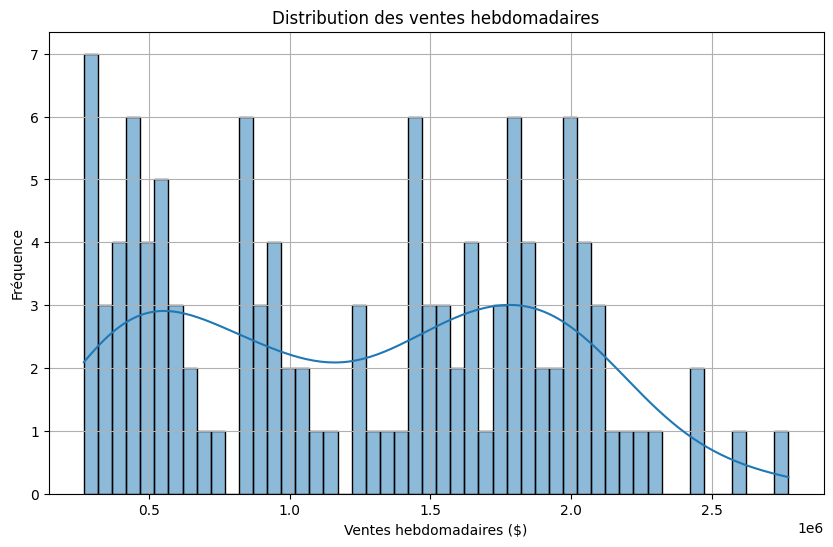

In [508]:
plt.figure(figsize=(10, 6))
sns.histplot(sales_df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution des ventes hebdomadaires')
plt.xlabel('Ventes hebdomadaires ($)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

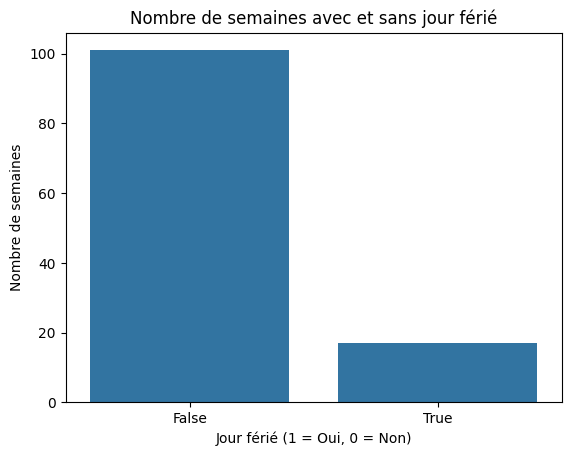

In [509]:
sns.countplot(data=sales_df, x='Holiday_Flag')
plt.title("Nombre de semaines avec et sans jour férié")
plt.xlabel("Jour férié (1 = Oui, 0 = Non)")
plt.ylabel("Nombre de semaines")
plt.show()

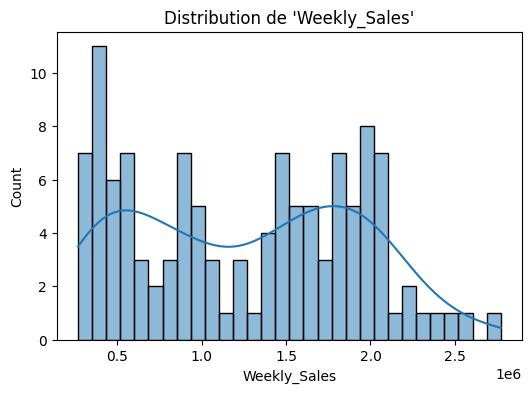

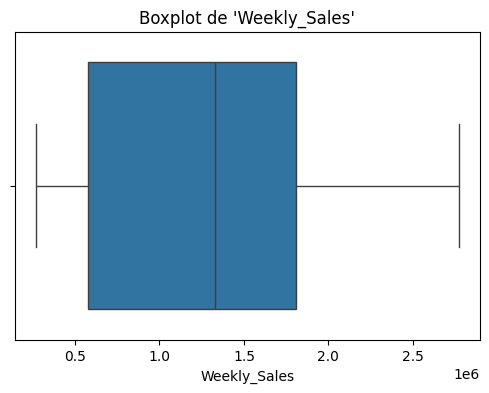

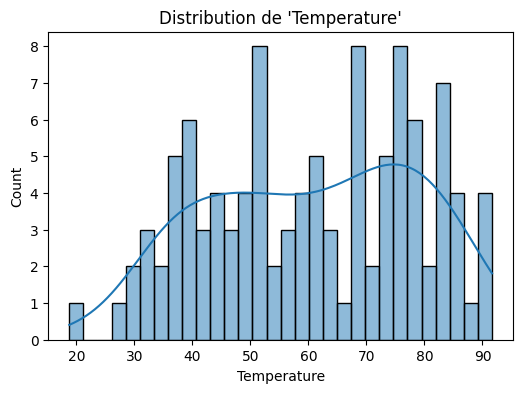

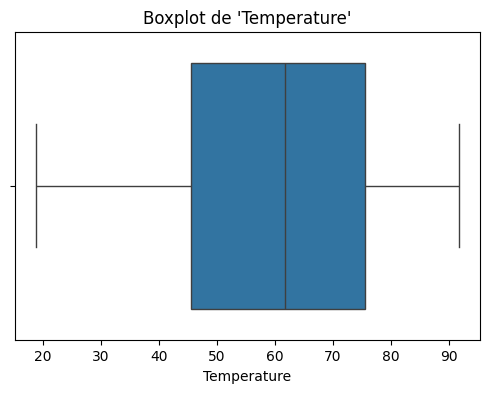

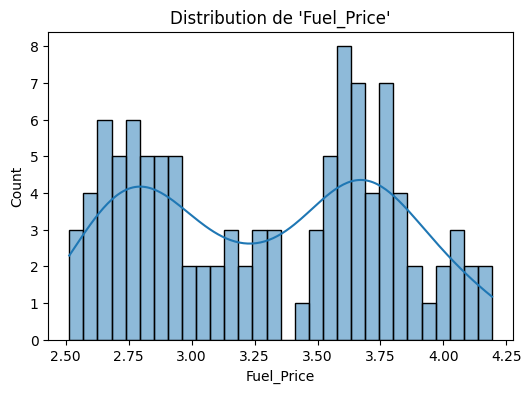

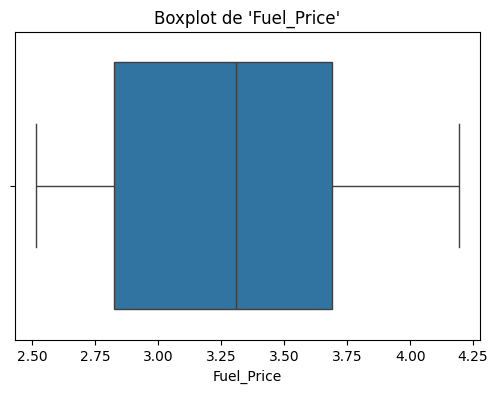

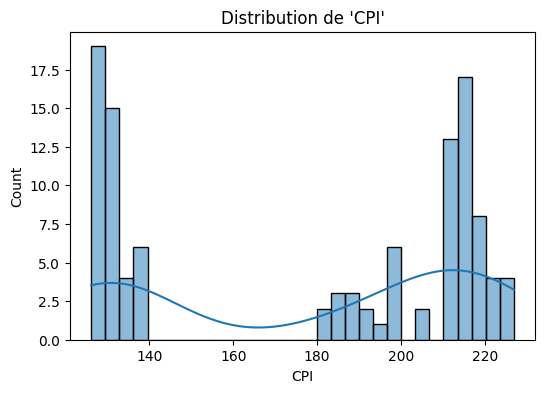

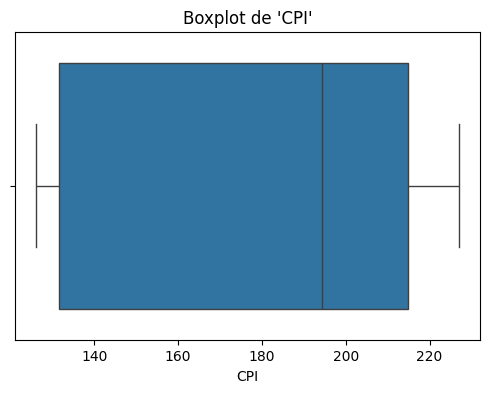

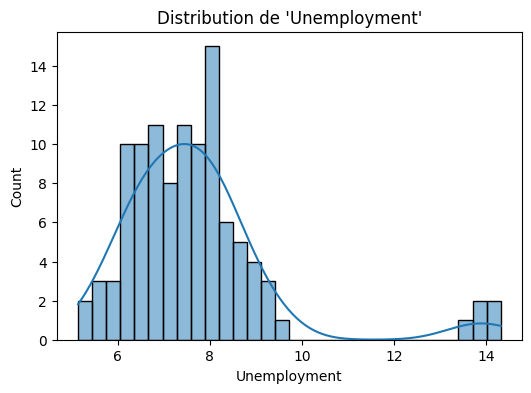

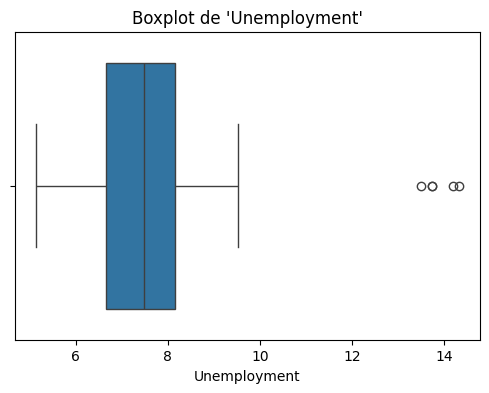

In [510]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(sales_df[col], kde=True, bins=30)
    plt.title(f"Distribution de '{col}'")
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=sales_df[col])
    plt.title(f"Boxplot de '{col}'")
    plt.show()

#### Analyse bivariée

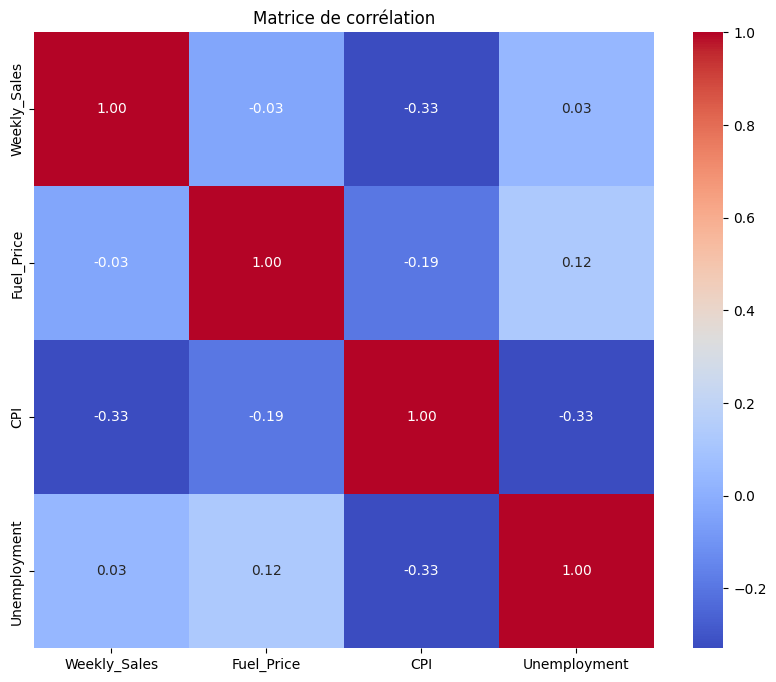

In [511]:
plt.figure(figsize=(10, 8))
corr_matrix = sales_df[['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

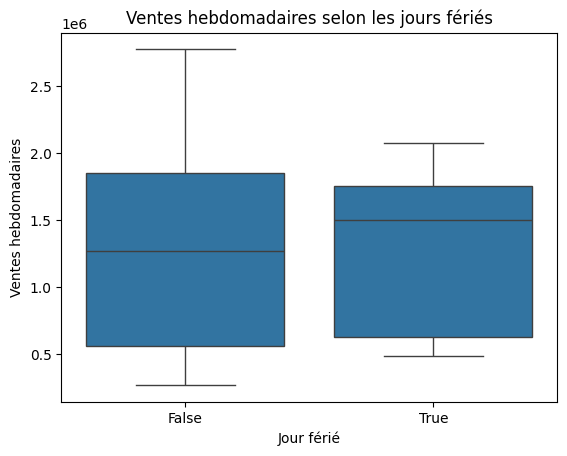

In [512]:
sns.boxplot(data=sales_df, x='Holiday_Flag', y='Weekly_Sales')
plt.title('Ventes hebdomadaires selon les jours fériés')
plt.xlabel('Jour férié')
plt.ylabel('Ventes hebdomadaires')
plt.show()


#### Analyse temporelle

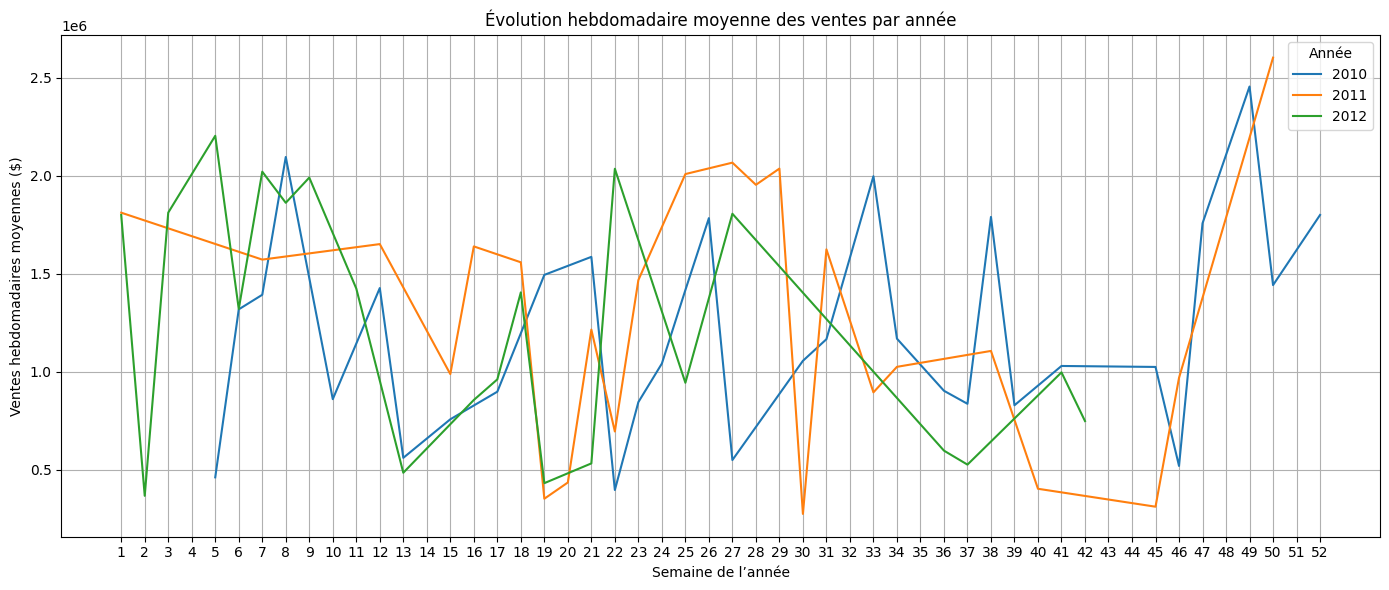

In [513]:
# moyenne des ventes par semaine et par année
weekly_sales_by_year = sales_df.groupby(['Year', 'Week'])['Weekly_Sales'].mean().reset_index()

# plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales_by_year, x='Week', y='Weekly_Sales', hue='Year', palette='tab10')
plt.title('Évolution hebdomadaire moyenne des ventes par année')
plt.xlabel('Semaine de l’année')
plt.ylabel('Ventes hebdomadaires moyennes ($)')
plt.xticks(range(1, 53))
plt.grid(True)
plt.legend(title='Année')
plt.tight_layout()
plt.show()


Pas assez de données pour avoir un graphe parlant à la semaine.

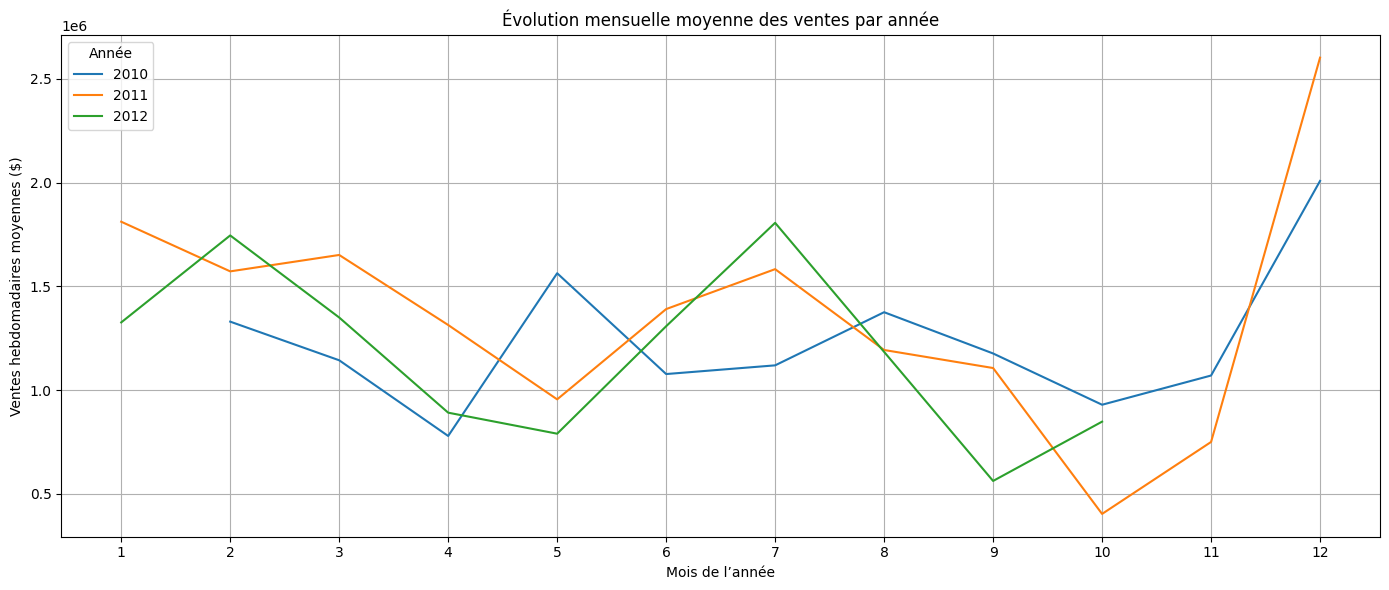

In [514]:
# moyenne des ventes par mois et par année
monthly_sales_by_year = sales_df.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()

# plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales_by_year, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
plt.title('Évolution mensuelle moyenne des ventes par année')
plt.xlabel('Mois de l’année')
plt.ylabel('Ventes hebdomadaires moyennes ($)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title='Année')
plt.tight_layout()
plt.show()

Là aussi, ça serait mieux avec plus de données! Mais on peut déjà mieux entrevoir quelques tendances saisonnières.

#### Analyse par magasin

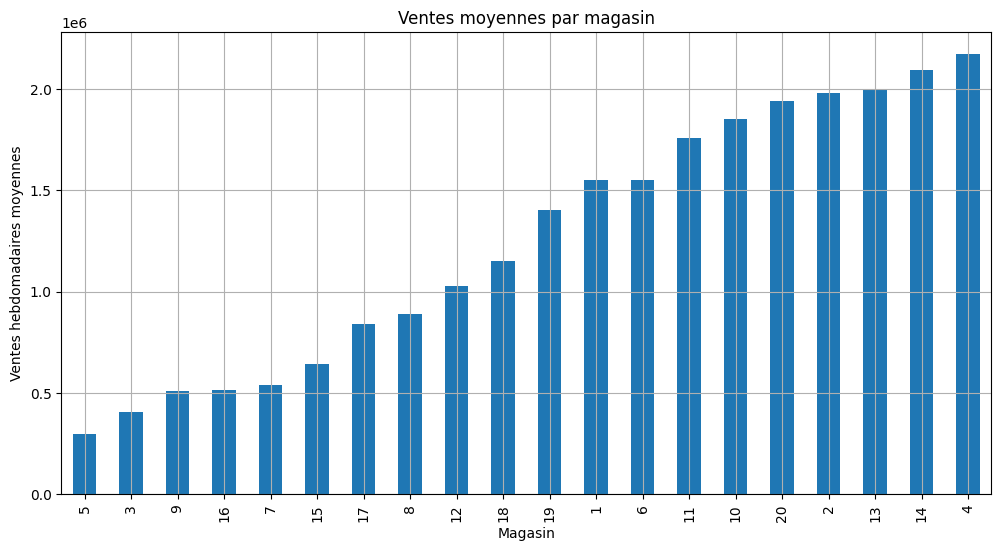

In [515]:
store_sales = sales_df.groupby('Store')['Weekly_Sales'].mean().sort_values()

plt.figure(figsize=(12, 6))
store_sales.plot(kind='bar')
plt.title('Ventes moyennes par magasin')
plt.xlabel('Magasin')
plt.ylabel('Ventes hebdomadaires moyennes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


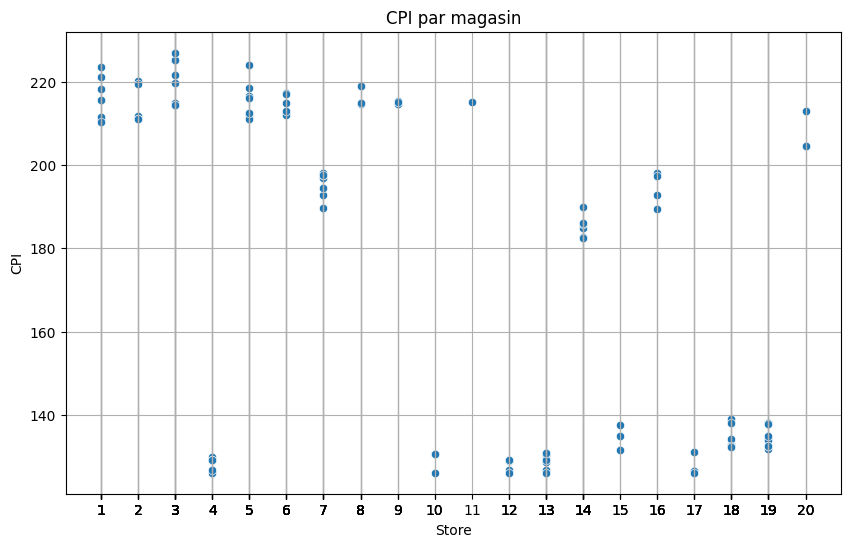

In [516]:
# CPI en fonction du magasin
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_df, x='Store', y='CPI')
plt.title('CPI par magasin')
plt.xlabel('Store')
plt.ylabel('CPI')
plt.xticks(sales_df['Store']) 
plt.grid(True)
plt.show()

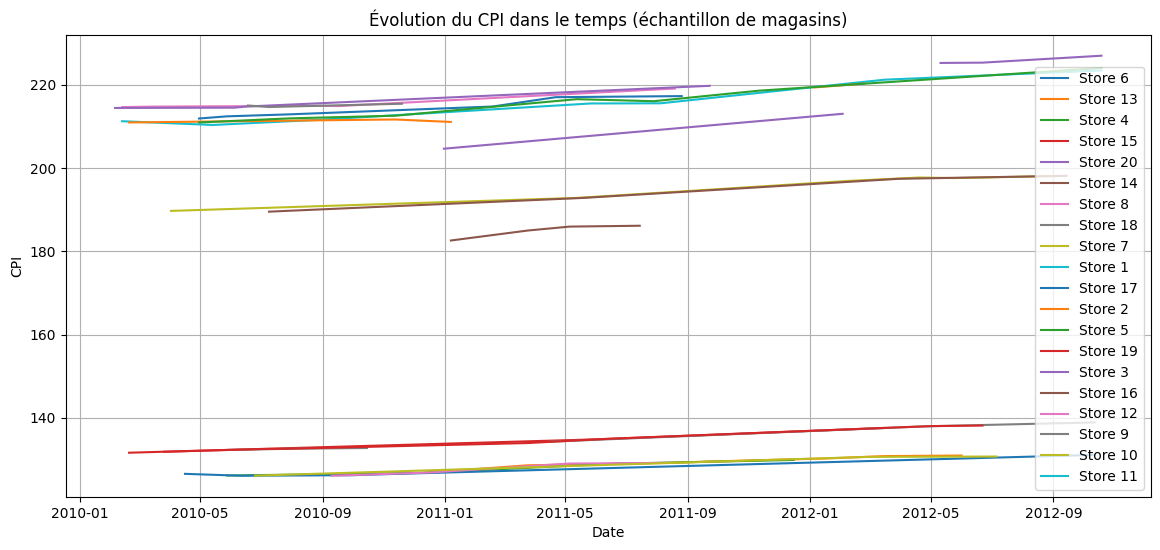

In [517]:
# Sélection de quelques magasins
stores_sample = sales_df['Store'].unique() # [:5]

plt.figure(figsize=(14, 6))
for store in stores_sample:
    subset = sales_df[sales_df['Store'] == store]
    subset = subset.sort_values('Date')
    plt.plot(subset['Date'], subset['CPI'], label=f'Store {store}')

plt.title('Évolution du CPI dans le temps (échantillon de magasins)')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.show()


Les prix augmentent, évidemment...

#### Synthèse

In [518]:
holiday_means = sales_df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
sell_holiday = round(holiday_means.iloc[1], 2)
sell_no_holiday = round(holiday_means.iloc[0], 2)
print("Moyenne des ventes SANS jour férié :", sell_no_holiday)
print("Moyenne des ventes AVEC jour férié :", sell_holiday)

ratio_no_holiday = (sell_holiday - sell_no_holiday) * 100 / sell_no_holiday

print("Le pourcentage de vente en HOLIDAY, par rapport à NO_HOLIDAY est de :", ratio_no_holiday)

Moyenne des ventes SANS jour férié : 1250538.3
Moyenne des ventes AVEC jour férié : 1297272.16
Le pourcentage de vente en HOLIDAY, par rapport à NO_HOLIDAY est de : 3.737099455490477


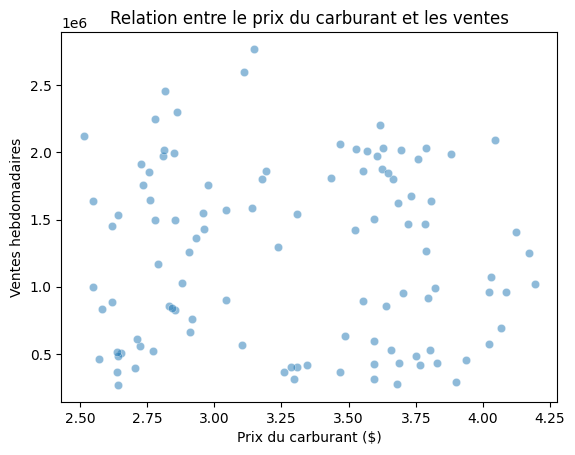

In [519]:
sns.scatterplot(data=sales_df, x='Fuel_Price', y='Weekly_Sales', alpha=0.5)
plt.title('Relation entre le prix du carburant et les ventes')
plt.xlabel('Prix du carburant ($)')
plt.ylabel('Ventes hebdomadaires')
plt.show()

- Les ventes ont une distribution très asymétrique (forte variance entre magasins).
- L’impact des jours fériés semble significatif (5%).
- Des tendances temporelles (saisonnalité) apparaissent.
- Certaines variables économiques comme le chômage ou le prix du carburant pourraient avoir une influence marginale.

- Une seule valeur pour weekday => inutile

### Outliers

La demande initiale est de supprimer toutes les lignes ayant une valeur invalide ou en dehors du range $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$ pour les valeurs numériques (`Temperature`, `Fuel_price`, `CPI` and `Unemployment`).

Toutefois, ayant peu de lignes, on va tenter d'en sauver quelques une, notamment en faisant de l'imputation.

In [520]:
# Unemployment et Fuel_Price ayant une correlation assez faible (peu d'influence), on va imputater par la médiane et garder ainsi les lignes NA.
# Done by imputer
# sales_df["Unemployment"] = sales_df["Unemployment"].fillna(sales_df["Unemployment"].median())
# sales_df["Fuel_Price"] = sales_df["Fuel_Price"].fillna(sales_df["Fuel_Price"].median())


In [521]:
# Pour les valeurs spécifiques à chaque magasin on pourrait envisager un mécanisme similaire mais basé sur les valeurs de ce magasin.
# Ainsi, pour les valeurs temporelles on prendrait la moyenne des points entourant la valeur manquante.
#
# PoC
df = sales_df.sort_values(by=['Store', 'Date'])

# Fonction pour imputer les valeurs manquantes avec la moyenne des points avant et après
def impute_with_mean_before_after(group):
    group = group.copy()  # Travailler sur une copie pour éviter de modifier les colonnes de regroupement
    for i in range(len(group)):
        if pd.isna(group['CPI'].iloc[i]):
            if i > 0 and i < len(group) - 1:
                # Calculer la moyenne des points avant et après
                mean_value = (group['CPI'].iloc[i-1] + group['CPI'].iloc[i+1]) / 2
                group.loc[group.index[i], 'CPI'] = mean_value
            elif i == 0 and i < len(group) - 1:
                # Si c'est le premier point, utiliser le point après
                group.loc[group.index[i], 'CPI'] = group['CPI'].iloc[i+1]
            elif i > 0 and i == len(group) - 1:
                # Si c'est le dernier point, utiliser le point avant
                group.loc[group.index[i], 'CPI'] = group['CPI'].iloc[i-1]
    return group

# Appliquer la fonction à chaque groupe de magasins
df["CPI"] = df.groupby("Store", group_keys=False)[["CPI"]].apply(impute_with_mean_before_after)

display(df)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,DayOfWeek
44,1,2010-02-12,1641957.44,True,38.51,2.548,211.242170,8.106,2010,2,6,12,4
95,1,2010-05-14,1494251.50,False,74.78,2.854,210.337426,7.808,2010,5,19,14,4
73,1,2010-08-27,1449142.92,True,85.22,2.619,211.567306,7.787,2010,8,34,27,4
123,1,2011-05-27,1466046.67,False,NaN,3.786,215.503788,7.682,2011,5,21,27,4
48,1,2011-08-05,1624383.75,True,91.65,3.684,215.544618,7.962,2011,8,31,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,19,2012-06-22,1468350.36,False,NaN,3.722,138.162900,8.150,2012,6,25,22,4
75,20,2010-06-25,1973135.87,False,75.17,2.808,204.567546,7.856,2010,6,25,25,4
79,20,2010-09-24,1789687.65,False,69.37,NaN,204.605386,7.527,2010,9,38,24,4
110,20,2010-12-31,1799737.79,True,28.85,3.179,204.643227,7.484,2010,12,52,31,4


<span style="color:red">Non appliqué</span> : le nombre de points disponible semble trop faible, pour que cette méthode ai du sens.

In [522]:
outliers_df = sales_df.copy()

# Suppression des lignes contenant des valeurs invalides ou des valeurs aberrantes pour les colonnes :   
for col in ["Temperature", "Fuel_Price", "CPI", "Unemployment"]:
    col_std = outliers_df[col].std()
    col_mean = outliers_df[col].mean()
    min_range = col_mean - 3 * col_std
    max_range = col_mean + 3 * col_std
    outliers_df = outliers_df.drop(outliers_df.loc[(outliers_df[col] < min_range) | (outliers_df[col] > max_range)].index, axis=0)

print("Shape            : ", sales_df.shape)
print("Without outliers : ", outliers_df.shape)

sales_df = outliers_df
# Use SimpleImputer
# na_df = outliers_df.dropna()
# print("Without NA       : ", na_df.shape)
# sales_df = na_df

Shape            :  (118, 13)
Without outliers :  (113, 13)


Encore des pertes...

A tester un simple remplacement ?
```python
print("Shape : avant", sales_df.shape)
for col in ["Temperature", "Unemployment", "Weekly_Sales", "Fuel_Price", "CPI"] :
    col_std = sales_df[col].std()
    col_mean = sales_df[col].mean()
    min_range = col_mean - 3 * col_std
    max_range = col_mean + 3 * col_std

    subst_val = sales_df[col].median() # ou mean() mais vu les distribution non gaussienne median est recommandé.

    sales_df[col] = sales_df[col].apply(lambda x : subst_val if x < min_range or x > max_range else x)
    
print("Shape : après", sales_df.shape)
```

## Part 2 : Entainement d'un modèle linaire (baseline)

### Préprocessing Pipeline

In [523]:
target_feature = "Weekly_Sales"

numerical_features = ["CPI", "Temperature", "Unemployment", "Fuel_Price"]

# We just keep month and week as temporal indicators, due to cyclic pattern
categorical_features = ["Store", "Holiday_Flag", "Month", "Week"]

# Imputer:
# - mean si distribution symétrique (gaussienne)
# - median si distribution asymétrique (avec outliers)
# On n'a pas de vrai gaussienne dans nos valeurs numériques.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features
])

col_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

col_preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CPI', 'Temperature', 'Unemployment',
                                  'Fuel_Price']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Store', 'Holiday_Flag', 'Month', 'Week'])])

In [524]:
sales_df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,DayOfWeek
0,6,2011-02-18,1572117.54,True,59.61,3.045,214.777523,6.858,2011,2,7,18,4
1,13,2011-03-25,1807545.43,False,42.38,3.435,128.616064,7.470,2011,3,12,25,4
4,6,2010-05-28,1644470.66,False,78.89,2.759,212.412888,7.092,2010,5,21,28,4
5,4,2010-05-28,1857533.70,False,NaN,2.756,126.160226,7.896,2010,5,21,28,4
6,15,2011-06-03,695396.19,False,69.80,4.069,134.855161,7.658,2011,6,22,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,3,2012-10-19,424513.08,False,73.44,3.594,226.968844,6.034,2012,10,42,19,4
145,14,2010-06-18,2248645.59,False,72.62,2.780,182.442420,8.899,2010,6,24,18,4
147,17,2010-06-11,845252.21,False,57.14,2.841,126.111903,NaN,2010,6,23,11,4
148,8,2011-08-12,856796.10,False,86.05,3.638,219.007525,NaN,2011,8,32,12,4


In [525]:
X_df = sales_df[numerical_features + categorical_features] # ['Store', 'CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag', 'Month']]
y_df = sales_df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42) 

In [526]:
X_test.dtypes

CPI             float64
Temperature     float64
Unemployment    float64
Fuel_Price      float64
Store             int64
Holiday_Flag       bool
Month             Int32
Week             UInt32
dtype: object

### Entainement du modèle

In [527]:
baseline_pipeline = Pipeline([
    ("preprocessing", col_preprocessor),
    ("regressor", LinearRegression()),
])

baseline_pipeline.fit(X_train, y_train)

baseline_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CPI', 'Temperature',
                                                   'Unemployment',
                                                   'Fuel_Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Holiday_Flag',
                                                   'Month', 'Week'])])),
                ('regressor', LinearRegression())])

In [528]:
def evaluate(model, name, X_train_arg, X_test_arg, y_train_arg, y_test_arg):
    y_train_pred = model.predict(X_train_arg)
    y_test_pred = model.predict(X_test_arg)
    
    train_r2_score = r2_score(y_train_arg, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_arg, y_train_pred))
    
    test_r2_score = r2_score(y_test_arg, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_arg, y_test_pred))

    print(" "*60)
    print(f"📈 {name}:")
    print(f"Train - R²   : {train_r2_score:.4f}")
    print(f"Train - RMSE : {train_rmse:.4f}")
    print(f"Test - R²    : {test_r2_score:.4f}")
    print(f"Test - RMSE  : {test_rmse:.4f}")
    
    metrics = {
        "train_r2_score": train_r2_score,
        "train_rmse": train_rmse,
        "test_r2_score": test_r2_score,
        "test_rmse": test_rmse
    }

    return metrics

In [529]:
baseline_metrics = evaluate(baseline_pipeline, "baseline_pipeline", X_train, X_test, y_train, y_test)

                                                            
📈 baseline_pipeline:
Train - R²   : 0.9970
Train - RMSE : 37626.2324
Test - R²    : 0.9337
Test - RMSE  : 150051.5234


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



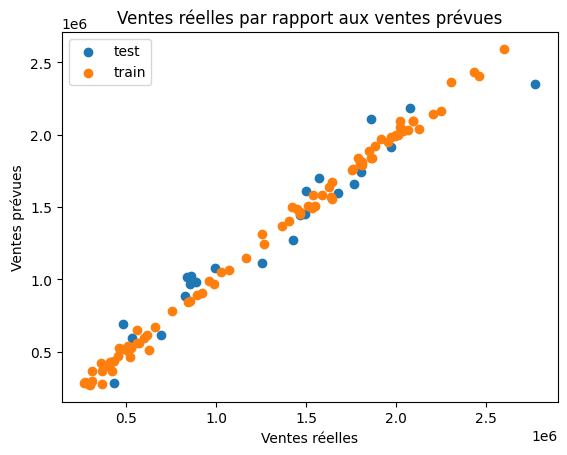

In [530]:
y_train_pred = baseline_pipeline.predict(X_train)
y_test_pred = baseline_pipeline.predict(X_test)

# visualisation des performances du modèle
plt.scatter(y_test, y_test_pred, label="test") 
plt.scatter(y_train, y_train_pred, label="train") 
plt.xlabel("Ventes réelles") 
plt.ylabel("Ventes prévues") 
plt.title("Ventes réelles par rapport aux ventes prévues")
plt.legend()
plt.show()

In [531]:
def show_feature_importance(reg_pipeline, num_cols, cat_cols, model_title):
    # Get feature names and impact coeffs
    #
    preprocessor = reg_pipeline.named_steps['preprocessing']

    # 1. Noms des features numériques (inchangés)
    num_features = num_cols

    # 2. Noms OneHotEncodés pour les features catégorielles
    ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_feature_names = ohe.get_feature_names_out(cat_cols)

    # 3. Fusion des noms finaux
    all_feature_names = list(num_features) + list(cat_feature_names)

    regressor = reg_pipeline.named_steps['regressor']
    coefficients = regressor.coef_

    # Prepare for display
    #
    coef_df = pd.DataFrame({
        'feature': all_feature_names,
        'coefficient': coefficients
    })
    # Create a dataframe ordered by abs(coefficient)
    # limit to 40 parameters (we have a lot due to week of year feature)
    coef_df_sorted = coef_df.reindex(coef_df["coefficient"].abs().sort_values(ascending=False).index).head(40)

    # Display
    #
    plt.figure(figsize=(12, 6))
    plt.bar(coef_df_sorted['feature'], coef_df_sorted['coefficient'], color='mediumseagreen')
    plt.ylabel("coefficient")
    plt.title(f"Importance des variables ({model_title})")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    

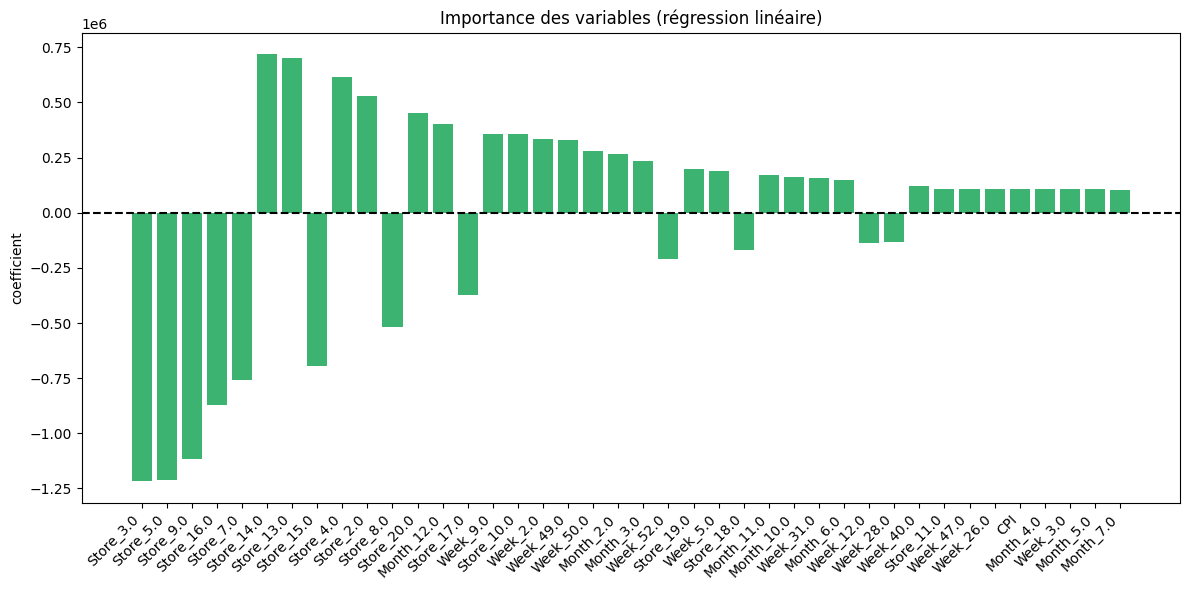

In [532]:
show_feature_importance(baseline_pipeline, numerical_features, categorical_features, "régression linéaire")

- Le Store (ID du magasin) a un fort impact
- Ensuite on décèle les mois et semaines les plus associés à des phases cycliques
- Puis CPI (par ailleurs corrélé au magasin)

## Part 3 : Limiter l'impact du surapprentissage

- Ridge
- Lasso

### Ridge

In [533]:
# Valeurs de alpha à tester (force de régularisation)
# alphas = np.logspace(-3, 3, 50)
# after first trials it was around 0.050, let refine
alphas = [0.047, 0.048, 0.049, 0.050, 0.051, 0.052, 0.053, 0.1]

# Ridge avec validation croisée intégrée
ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_pipeline = Pipeline(steps=[
    ('preprocessing', col_preprocessor),
    ('regressor', ridge_model)
])
ridge_pipeline.fit(X_train, y_train)

print("Alpha: ", ridge_pipeline["regressor"].alpha_)

ridge_pipeline

Alpha:  0.048


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CPI', 'Temperature',
                                                   'Unemployment',
                                                   'Fuel_Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Holiday_Flag',
                                                   'Month', 'Week'])])),
                ('regressor',
                 RidgeCV(alphas=[0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053,
                                 0.1],
                         cv=5))])

In [534]:
ridge_metrics = evaluate(ridge_pipeline, "Ridge", X_train, X_test, y_train, y_test)

                                                            
📈 Ridge:
Train - R²   : 0.9965
Train - RMSE : 40912.6467
Test - R²    : 0.9272
Test - RMSE  : 157254.5549


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



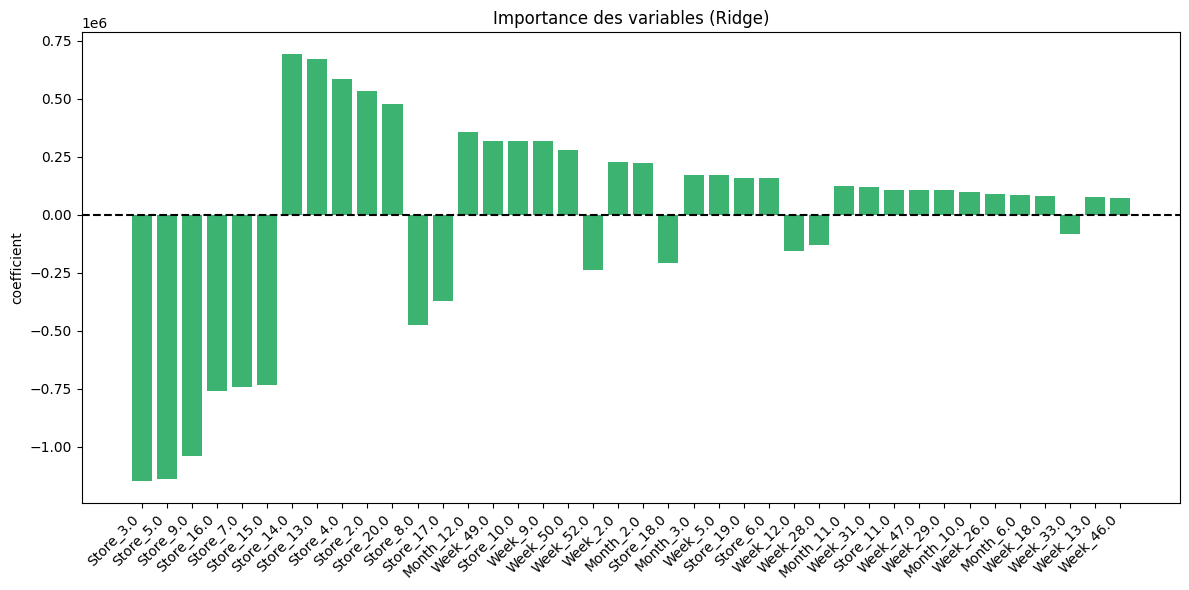

In [542]:
show_feature_importance(ridge_pipeline, numerical_features, categorical_features, "Ridge")

### Lasso

In [536]:
# Lasso avec validation croisée intégrée
alphas = [0.001, 0.01, 0.1, 1, 2, 5, 100, 200, 500, 1000, 2000, 5000, 10000]

lasso_model = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_pipeline = Pipeline(steps=[
    ('preprocessing', col_preprocessor),
    ('regressor', lasso_model)
])
lasso_pipeline.fit(X_train, y_train)

print("Alpha: ", lasso_pipeline["regressor"].alpha_)

lasso_pipeline

Alpha:  1000.0


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CPI', 'Temperature',
                                                   'Unemployment',
                                                   'Fuel_Price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Holiday_Flag',
                                                   'Month', 'Week'])])),
                ('regressor',
                 LassoCV(alphas=[0.001, 0.01, 0.1, 1, 2, 5, 100, 200, 500, 1000,
                                 2000, 5000, 10000],
                         cv=5, max_iter=10000))])

In [537]:
lasso_metrics = evaluate(lasso_pipeline, "Lasso", X_train, X_test, y_train, y_test)


                                                            
📈 Lasso:
Train - R²   : 0.9919
Train - RMSE : 62227.8200
Test - R²    : 0.9523
Test - RMSE  : 127317.2292


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



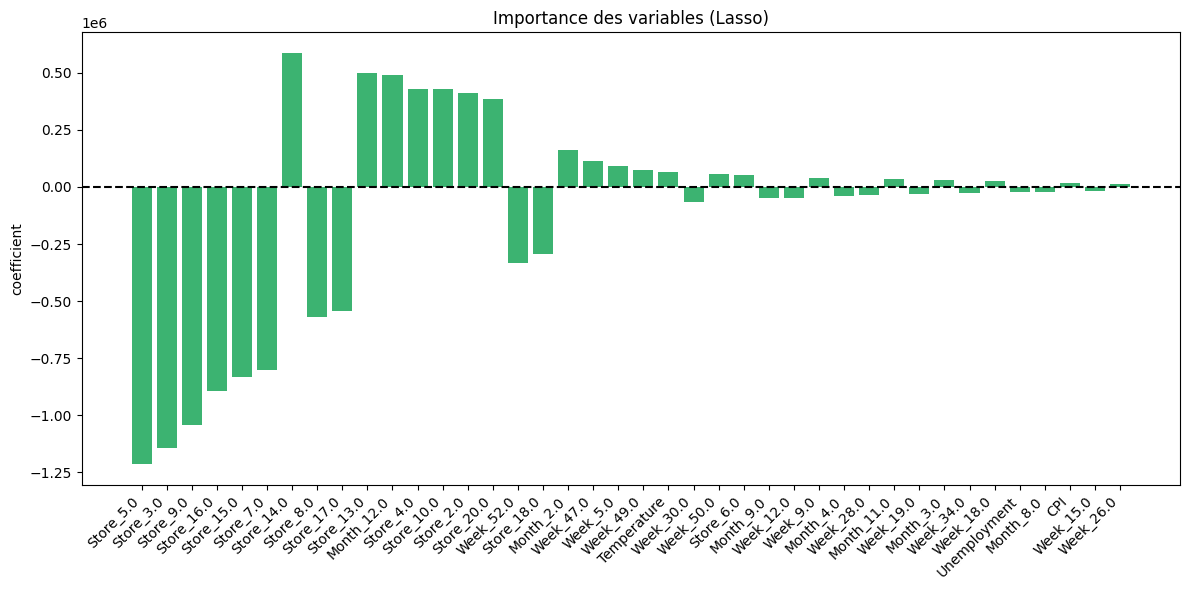

In [541]:
show_feature_importance(lasso_pipeline, numerical_features, categorical_features, "Lasso")

Lasso permet de confirmer l'impact des magasins sur la prediction!


## Conclusion

In [539]:
baseline_metrics["model"] = "Linéaire"
ridge_metrics["model"] = "Ridge"
lasso_metrics["model"] = "Lasso"

metrics_df = pd.DataFrame([baseline_metrics, ridge_metrics, lasso_metrics])
metrics_df.sort_values("test_r2_score", ascending=False)


,train_r2_score,train_rmse,test_r2_score,test_rmse,model
2,0.991919,62227.819974,0.952252,127317.229170,Lasso
0,0.997046,37626.232374,0.933677,150051.523423,Linéaire
1,0.996507,40912.646705,0.927157,157254.554932,Ridge


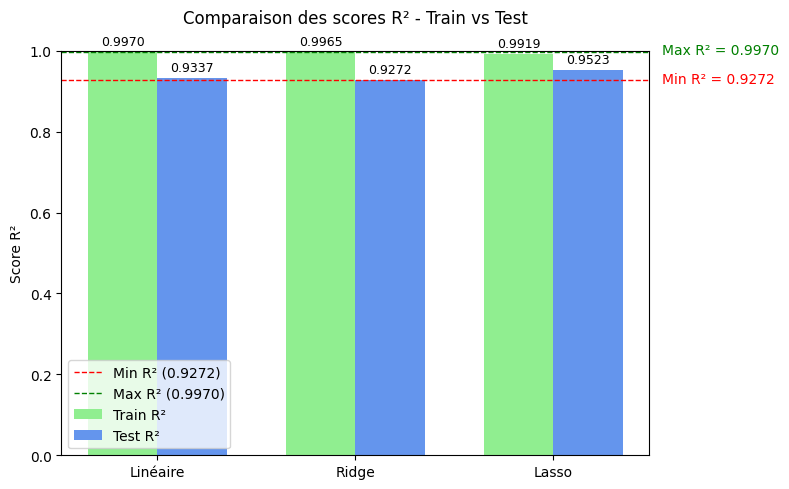

In [540]:
# Valeurs à adapter selon tes résultats réels
models = ["Linéaire", "Ridge", "Lasso"]
train_r2_values = metrics_df["train_r2_score"].values.tolist()
test_r2_values = metrics_df["test_r2_score"].values.tolist()

x = np.arange(len(models))
width = 0.35

# Définir les min / max pour les lignes horizontales
r2_all = train_r2_values + test_r2_values
r2_min = min(r2_all)
r2_max = max(r2_all)

fig, ax = plt.subplots(figsize=(8, 5))

# Barres train / test
bars1 = ax.bar(x - width/2, train_r2_values, width, label='Train R²', color='lightgreen')
bars2 = ax.bar(x + width/2, test_r2_values, width, label='Test R²', color='cornflowerblue')

# Lignes horizontales min/max
ax.axhline(r2_min, color='red', linestyle='--', linewidth=1, label=f'Min R² ({r2_min:.4f})')
ax.axhline(r2_max, color='green', linestyle='--', linewidth=1, label=f'Max R² ({r2_max:.4f})')

# Annotation des lignes à droite
x_text = len(models) - 0.45  # position horizontale (légèrement à droite)

ax.text(x_text, r2_min - 0.006, f"Min R² = {r2_min:.4f}", color='red')
ax.text(x_text, r2_max - 0.006, f"Max R² = {r2_max:.4f}", color='green')

# Légendes et titres
ax.set_ylabel('Score R²')
ax.set_title('Comparaison des scores R² - Train vs Test', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

# Affichage des valeurs au-dessus des barres
for bars, values in zip([bars1, bars2], [train_r2_values, test_r2_values]):
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, val + 0.01, f"{val:.4f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

- Peu de données => prédictions certainement peu généralisable aux futures entrées.
- Predictions trés liées au magasin => ne sera probablement pas trés pertinent sur un nouveau magasin. (il y a certainement besoin de données locales plus élaborées: population, temps de trajet / nombre de personne, salaire moyen...)

- Les 3 modèles, dans le contexter de notre jeu de données, présentent de très bonnes performances sur les données d'entraînement, avec des scores R² supérieurs à 0.99 (!). Cela montre qu’ils capturent bien la structure sous-jacente des données.
- En test, Lasso obtient les meilleurs résultats, avec un score R² de 0.95 et un RMSE de 127 317, inférieur aux deux autres modèles. Il semble ce cette méthode parvient à réduire le sur-apprentissage observé chez les autres, tout en maintenant une bonne précision.
- La Régression Linéaire et Ridge sont assez proches en termes de performance, mais moins bien en généralisation (écart plus marqué entre leurs scores d'entraînement et de test).
- Dans notre cas, Lasso a permis une selection des variables plutôt pertinente.

